# COMP1801 Tutorial Week 8 - Neural Networks
*Dr Peter Soar - 2023/24*
$\newcommand{\Vec}[1]{\boldsymbol{#1}}$
$\newcommand{\Mat}[1]{\boldsymbol{#1}}$

This tutorial should be pulling together everything we have been learning so far in supervised learning. Neural Networks can be applied to both Regression and Classification problems to create complex deep learning models which if constructed and trained correctly should generally outperform any traditional linear models we've been dealing with so far. This tutorial should show you how to implement a general neural network using `tensorflow.keras` by combining different types of layers.

For this tutorial, read through and try to understand the text and code examples I have provided (ask your tutor if you have any questions) and there will be a selection of exercises. Attempt these exercises on your own, but do ask your tutor for help if you get stuck.

### Note: USE **GOOGLE COLAB** (not offline environments) to use Tensorflow.

*   Tensorflow enables you to leverage GPUs.
*   Installing Tensorflow to your laptop/PC may cause technical problems.
*   **Ensure runtime is changed to GPU** to accelerate execution speed.

#0. Do not forget to import all the Python Libraries being used!

In [2]:
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices.
import pandas as pd # A common package for viewing tabular data
import sklearn.datasets # We want to be able to access the sklearn datasets again
from sklearn.preprocessing import StandardScaler # We will be using the imbuilt scaling functions sklearn provides
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
from sklearn.model_selection import train_test_split # A library that can automatically perform data splitting for us
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score # Various classification metrics we may find useful

# Below are a wide selection of tensorflow libraries we will need to construct our Neural networks.
from tensorflow.keras.activations import sigmoid, linear, relu, softmax # Activation functions we will use
from tensorflow.keras.models import Model, Sequential # Different mays of constructing models, we will primarily be covering the 'functional api' which uses `Model`
from tensorflow.keras.optimizers import SGD # We will be using the SGD optimiser today, though there are other options you may want to explore (such as Adam)
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy  # We will be using TFs MSE loss function for regression and BinaryCross Entropy for classification.
from tensorflow.keras.layers import Input, Dense, Dropout # The layers we will be using to construct our network.
from tensorflow.keras.regularizers import L1, L2 # Regularisation being used in model layers
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy # Accuracy Metric for classification
from tensorflow.keras.callbacks import EarlyStopping # Allows Early Stopping regularisation method.

#1. Basic pipeline of implementing a neural network model in `tensorflow.keras` (Regression case).
We can implement various neural networks using `tensorflow.keras`. First, we discuss multi-layer perceptron (fully connected neural network) as the easiest model before going into trying to construct more complicated models in the exercises.

## 1.1 Data preparation

Load the house price data:

To keep things straightforward and get straight to building the Neural Networks, we don't want to deal with data cleansing and EDA. For this reason, we will be take the now very familiar California House Price dataset (and later for classification the breast cancer dataset) as our examples.


In [3]:
# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# Display the whole dataset
XY_pd = pd.concat([X_pd, y_pd], axis=1)
display(XY_pd)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


Data splitting:

We first convert the data into `numpy.ndarray`, then apply the `sklearn.model_selection.train_test_split` function.

In [4]:
# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
y = y_pd.to_numpy()

# Split the data into training/test data
# While we have 20640 pairs of a feature and target, we use 20% only for the test, not for training and validation.
# `shuffle=True` for non-time series case. You should set `shuffle=False` to avoid future data being contaminated in the training data.
X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

Pre-processing:

Fit a `sklearn.preprocessing.StandardScaler` instance to the training data, then transpose the validation and test data by the instance.

For advanced preprocessing operations for images and text (which we won't be covering in this module, but may be of interest for your MSc projects or in Applied Machine Learning next term), you can also use classes defined in the `tensorflow.keras.preprocessing` module ([see here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing)).


In [5]:
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

Confirm the shape of the feature matrix:

While it is always a good idea to check the dimensions of your data, this is particularly important when defining a neural network in `tensorflow.keras` as we need to know the shape (dimension) of the input (feature).

In [6]:
print('The shape of `X_train`:', X_train.shape)
print('The shape of `X_valid`:', X_valid.shape)
print('The shape of `X_test`:', X_test.shape)

The shape of `X_train`: (12384, 8)
The shape of `X_valid`: (4128, 8)
The shape of `X_test`: (4128, 8)


The above results show that, for example, we have 12384 data points in the training data, and the features of each data point is 8-dimensional.

## 1.2 Create a neural network model by composing `tensorflow.keras` layers.
In the machine learning context, many of the models we have been spending a long time working with are defined as a parametrized function, so our task here is how we can achieve that for a Neural Network model.

In `tensorflow.keras`, we define this parametrized function by composing neural network layers, each of which are themselves a Neural Network. Likewise, the graph structure of the neural network is defined by the composition of these layers.



### 1.2.1 Define neural network layers
First, we create layer instances to be composed to define our neural network model. Specifically, we create instances of classes in the `tensorflow.keras.layers` module, specifying an activation function by taking a function in the `tensorflow.keras.activations` module as an `activation` argument in the initializer of the layer class.

As an example, we create `tensorflow.keras.layers.Dense` instances (fully connected layers) in the cell below.

The function defined by the `Dense` layer is as follows:
$$
{\Vec{a}^{\mathrm{out}}} = f (\Vec{b} + {\Vec{a}^{\mathrm{in}}} \Mat{W}),
$$
where

- ${\Vec{a}^{\mathrm{in}}}$: the input row vector of the layer. We denote the dimensionality of the ${\Vec{a}^{\mathrm{in}}}$ by $n^{\mathrm{in}}$.
- ${\Vec{a}^{\mathrm{out}}}$: the output row vector of the layer. We denote the dimensionality of the ${\Vec{a}^{\mathrm{out}}}$ by $n^{\mathrm{out}}$. We specify $n^{\mathrm{out}}$ by the `units` parameter in the `Dense` class's initializer.
- $\Mat{W}$: a matrix of size $n^{\mathrm{in}} \times n^{\mathrm{out}}$ called the "kernel" parameter of the layer. Each parameter of the matrix is a learnable parameter.
- $\Vec{b}$: an $n^{\mathrm{out}}$-dimensional row vector called the "bias" parameter of the layer. Each parameter of the vector is a learnable parameter.
- $f$: a scalar function called the "activation function" of the layer. Although $f$ is defined as a scalar function, it is applied to an $n^{\mathrm{out}}$-dimensional vector elementwisely in the layer. Note that $f$ is fixed and not learnable, that is, invariant throughout the training process. The activation function $f$ is specified by the `activation` parameter in the `Dense` class's initializer.

The activation function of the first and second layers we are going to use in this case is the sigmoid function given by `tensorflow.keras.activation.sigmoid` function, and that of the third layer is the identity function given by the `tensorflow.keras.activation.linear` function.

The sigmoid function $\varsigma$ is defined by
$$
\varsigma (z) = \frac{1}{1 + \exp(- z)},
$$
and the identity function $\mathop{\mathrm{id}}$ is defined by
$$
\mathop{\mathrm{id}} (z) = z.
$$

For other layers, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and for other activation functions, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/activations). I would say that while traditionally the sigmoid function was widely used in dense layers, it has now been largely superseded as the 'default' choice by the Relu function, which is less computationally expensive and less likely to suffer issues with vanishing gradients.
$$
ReLU(z) = max(0,z)
$$
Note: For regression problems we should always use the identity function, but the other activations become more important for classification.

In [7]:
# Define the first `Dense` layer.
# The output dimension is 5, so we specify `units=5`.
# The activation function is the sigmoid function, we specify `activation=sigmoid`.
first_layer = Dense(units=5, activation=sigmoid)

# Define the second `Dense` layer.
# The output dimension is 5, so we specify `units=5`.
# The activation function is the sigmoid function, we specify `activation=sigmoid`.
second_layer = Dense(units=5, activation=sigmoid)

# Define the third `Dense` layer.
# The output dimension is 1, so we specify `units=1`.
# The activation function is the identity function, we specify `activation=linear`.
third_layer = Dense(units=1, activation=linear)

### 1.2.2 Compose layers.

First, we create a `tensorflow.keras.layers.Input` instance as a **virtual input**, specifying the input shape as a `shape` argument in the initializer.
Here, we omit the data size (the number of data points) from the argument. For example, our training data shape (`X_train.shape`) is `(12384, 8)` where the zeroth element indicates the data size and the first element is the number of features/columns, which will be our input. Hence we can manually specify `shape=(8, )` or extract the data using `shape=X_train.shape[1:]`.


In [8]:
# Extract the number of features for our Networks input dimension
features=X_train.shape[1:]
# Define the "virtual" input
input = Input(shape=features)

Note: For image processing problems, the input shape is often like `(data_size, width, height, channels)`, meaning we specify `shape=(width, height, channels)`.



Once we create a `Input` instance, we "call" the first layer instance taking the `Input` instance as an argument.
Subsequently, we call the second layer instance taking the output of the first layer as an argument. We continue this process for as many layers as we require.


In [9]:

# Call the layers in a row to get a "virtual" output
output = first_layer(input)
output = second_layer(output)
output = third_layer(output)

Once we have composed our final virtual output, we can create a `tf.keras.models.Model` instance, taking the virtual input (the `Input` instance) and virtual output (the return value of the last layer). This `Model` instance is the NN model that we have implemented, that can now be trained on data and used to make predictions like we have done with the `linear` model instances in previous weeks.



In [10]:
# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='multi_layer_perceptron')

We can show the summary of our model by `summary` method of our `Model` instance. Which is always a good sanity check to ensure that our model seems to be functioning how we would expect.



In [11]:
model.summary()

Model: "multi_layer_perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Note: I am going to be using the TensorFlow functional API for creating Neural Networks in these tutorials. There are other methods, in particular the TensorFlow sequential API is very popular and probably a little easier to gasp from the start (See Appendix 1). The functional API has some advantages that allows for more complicated models to be constructed easily, but the sequential API is also fine for the majority of cases, and I do not mind which method you use to construct your NN's in your coursework.

## 1.2.3 Example of the hypothesis function created by above model
The above neural network represent the composition of the functions represented by the three `Dense` layers. Below is how we would write this NN model in functional form.

Let ${\Vec{x}}^\top$ be the input row vector. The output $\eta$ of the neural network is given by
$$
{\Vec{a}^{[1]}}^\top = \varsigma ({\Vec{b}^{[1]}}^\top + {\Vec{x}}^\top \Mat{W}^{[1]}), \\
{\Vec{a}^{[2]}}^\top = \varsigma ({\Vec{b}^{[2]}}^\top + {\Vec{a}^{[1]}}^\top \Mat{W}^{[2]}), \\
\eta = b^{[3]} + {\Vec{a}^{[2]}}^\top \Vec{w}^{[3]}. \\
$$
where

- $\Mat{W}^{[1]}$: the "kernel" parameter of the first layer, a matrix of size $8 \times 5$.
- ${\Vec{b}^{[1]}}^\top$: the "bias" parameter of the first layer, an $5$-dimensional row vector.
- $\Mat{W}^{[2]}$: the "kernel" parameter of the second layer, a matrix of size $5 \times 5$.
- ${\Vec{b}^{[2]}}^\top$: the "bias" parameter of the second layer, an $5$-dimensional row vector.
- $\Vec{w}^{[3]}$: the "kernel" parameter of the third layer, a 5-dimensional row vector.
- $b^{[3]}$: the "bias" parameter of the third layer, a scalar.

We can also write the function in one line as follows:

$$
\eta = b^{[3]} + \varsigma ({\Vec{b}^{[2]}}^\top + \varsigma ({\Vec{b}^{[1]}}^\top + {\Vec{x}}^\top \Mat{W}^{[1]}) \Mat{W}^{[2]}) \Vec{w}^{[3]}
$$

Which really underlines just how the outputs of multi-layered neural networks are really just nested parameterised functions.

## 1.3 Training the model.

### 1.3.1 "Compile" the model: specifying a loss function and optimizer.
Now we have defined a machine learning model as a set of parametrized functions, to train the model (or find the optimal parameters) we need to specify a loss function and an optimizer (an optimization algorithm).

We can applly this by "compiling" the model. We execute this process by the `compile` method of the `Model` instance.

In `tensorflow.keras`, we use an instance of a class in the `tensorflow.keras.losses` module as a loss function, and one in the `tensorflow.keras.optimizers` module as an optimizer. Specifically, we take a loss instance and optimizer instance as a `loss` and `optimizer` arguments of the `compile` method.

In the cell below, we use a `tensorflow.keras.losses.MeanSquaredError` instance as a loss function, and a `tensorflow.keras.optimizers.SGD` (vanilla stochastic gradient descent) instance as an optimizer. For other loss functions, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses) and for other optimizers, see  [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). `tensorflow.keras.optimizers.Adam` is also often used and ha become a very widely used 'default' optimiser.


In [12]:
# Compile the model by specifying the optimization algorithm and the loss function.
# Here, we specify the vanilla stochastic gradient descent
# (a `tensorflow.keras.optimizers.SGD` instance) as an optimizer,
# and mean squared error (a `MeanSquaredError` instance) as a loss function.
sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

### 1.3.2 "Fit" the model to the training data: Optimizing the parameters.
Similar to a machine learning model instance in `sklearn`, we can train a neural network machine learning model defined by `tensorflow` using the `fit` method. The `fit` method apply the **forwardpropagation and backpropagation** to calculate the gradient vector.  

Here, we specify the number of epochs (`epochs`) and the mini batch size (`batch_size`). The definitions of these terms are as follows:

In the optimization by a stochastic gradient descent method, each update does not consider all the training data points at the same time.
Instead, each update considers a subset of the dataset, called a **mini batch**.
We first shuffle the training data points and divide them into multiple mini batches.
Then, we update parameters based on the loss function and gradient vector for each mini batch.
A pass through the mini batches that cover all the training data points once is called an **epoch**.
Once we completed the updates based on all the mini batches in an epoch, we shuffle the training data points and divide them into new mini batches again, which begins a new epoch.

For example, if we have 12384 training data points and the mini batch size is 1000, each epoch contains 13 mini batches, where each of the first 12 mini batches contains 1000 training data points and the last mini batch contains 384 data points. Hence, each epoch conducts 13 updates. If the number of epochs is 10, the algorithm updates the parameters 13x10=130 times.

We can also input the validation data. If you input them, the loss function on the validation data will be displayed during the training. Note that the validation data does not affect the training results but can be used to identify overfitting.

Epoch 1/100
13/13 [==============================] - 10s 43ms/step - loss: 3.5445 - val_loss: 2.3104
Epoch 2/100
13/13 [==============================] - 0s 13ms/step - loss: 1.8680 - val_loss: 1.6236
Epoch 3/100
13/13 [==============================] - 0s 12ms/step - loss: 1.5002 - val_loss: 1.4650
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 1.4178 - val_loss: 1.4245
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 1.3967 - val_loss: 1.4109
Epoch 6/100
13/13 [==============================] - 0s 13ms/step - loss: 1.3884 - val_loss: 1.4040
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 1.3831 - val_loss: 1.3982
Epoch 8/100
13/13 [==============================] - 0s 9ms/step - loss: 1.3782 - val_loss: 1.3932
Epoch 9/100
13/13 [==============================] - 0s 10ms/step - loss: 1.3735 - val_loss: 1.3885
Epoch 10/100
13/13 [==============================] - 0s 12ms/step - loss: 1.3689 - val_loss: 1.3836
E

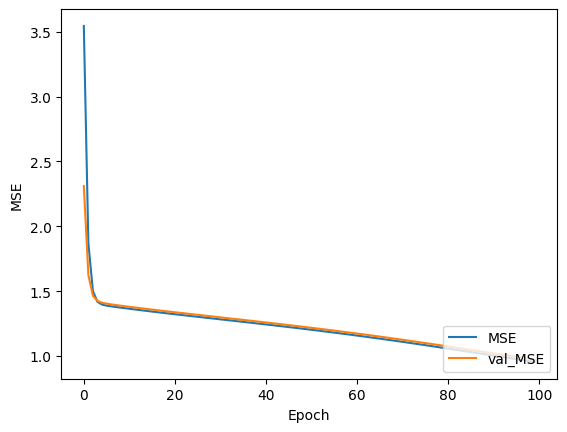

In [ ]:
# Train the model.
# `epochs` determines the number of epochs.
# `batch_size` determines the batch_size.
# We don't actually need to save the fit model to a new variable to train our model, but saving the output this ways lets us make a graph of the training and validation performance.
history = model.fit(X_train, y_train, batch_size=1000, epochs=100, validation_data=(X_valid, y_valid))

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')

You can see that each epoch contains 13 mini batches. `loss` and `val_loss` show the loss (the mean squared error) on the training data and the validation data, respectively. The losses decrease throughout the training and in this case our validation MSE is lower than our training, as both are still continuing to reduce there is no overfitting but we should consider training this model for longer.

## 1.4 Evaluation of the NN model
We can evaluate the loss function on a new dataset by the `evaluate` method of the `Model` instance.


In [ ]:
mse_on_test = model.evaluate(X_test, y_test)
print('The mean squared error on the test data:', mse_on_test)

129/129 [==============================] - 1s 6ms/step - loss: 0.9590
The mean squared error on the test data: 0.9589741826057434


This MSE looks to be in the same region as we saw for our validation data, so no evidence of overfitting here.
We can make a prediction using the `predict` method just as we did in the `sklearn` cases. We can see how these predictions compare with our observed values and calculate the score function just as we did with out linear models.

129/129 [==============================] - 1s 3ms/step


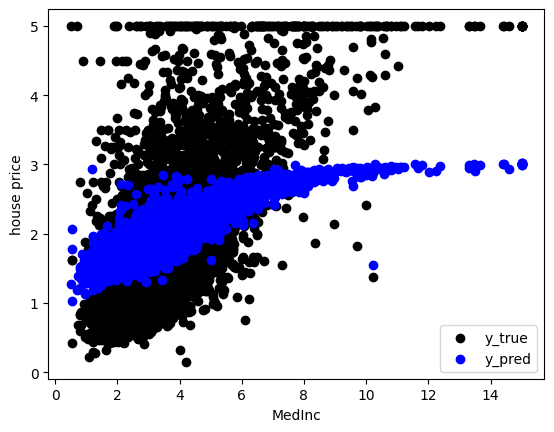

R2 score: 0.2646


In [ ]:
y_test_pred = model.predict(X_test)

# Plot our predictions
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_test_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_test_pred)))

## 1.5 Exercise 1
So, our model above is performing okay, but honestly the Neural Network we've made here isn't that great and clearly needs more training if nothing else. Don't spend too long on this, but manually experiment with the model to see if you can make it more accurate (ideally without just training it for 1000's of steps!).

Some things to try changing:
*   More hidden layers
*   More units in the hidden layers (remember that we generally want the same number of hidden units in each layer)
*   Different activation functions in the hidden layers (say `relu` which is probably more appropriate for this type of problem, but you can try others, again these should generally be the same for each layer other than the output.)
*   Different compiler option hyperparameters such as batch size, number of epochs, learning rate.

In [ ]:
##############################################################
# Your code here
##############################################################

##############################################################
# Your code here
##############################################################
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

X_raw = X_pd.to_numpy()
y = y_pd.to_numpy()


X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

first_layer = Dense(units=128*4, activation=relu)
second_layer = Dense(units=128*4, activation=relu)
third_layer = Dense(units=128*4, activation=relu)
forth_layer = Dense(units=128*4, activation=relu)
fifth_layer = Dense(units=128*4, activation=relu)
out_layer = Dense(units=1, activation=linear)

input = Input(shape=X_train.shape[1:])
output = first_layer(input)
output = second_layer(output)
output = third_layer(output)
output = forth_layer(output)
output = fifth_layer(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Exercise_1')
model.summary()

Model: "Exercise_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_3 (Dense)             (None, 512)               4608      
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 1)                 5

Epoch 1/100
13/13 [==============================] - 3s 25ms/step - loss: 3.0712 - val_loss: 1.7798
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 1.1334 - val_loss: 1.0492
Epoch 3/100
13/13 [==============================] - 0s 15ms/step - loss: 0.8297 - val_loss: 0.7924
Epoch 4/100
13/13 [==============================] - 0s 15ms/step - loss: 0.7090 - val_loss: 0.6964
Epoch 5/100
13/13 [==============================] - 0s 12ms/step - loss: 0.6552 - val_loss: 0.6535
Epoch 6/100
13/13 [==============================] - 0s 15ms/step - loss: 0.6252 - val_loss: 0.6292
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.6022 - val_loss: 0.6078
Epoch 8/100
13/13 [==============================] - 0s 9ms/step - loss: 0.5816 - val_loss: 0.5892
Epoch 9/100
13/13 [==============================] - 0s 9ms/step - loss: 0.5629 - val_loss: 0.5734
Epoch 10/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5455 - val_loss: 0.5554
Ep

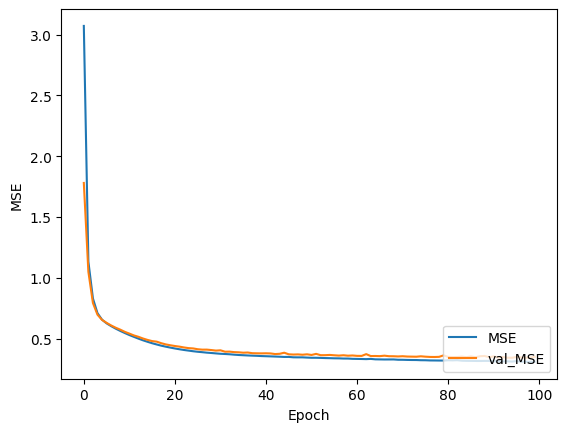

In [ ]:
# Compile the model by specifying the optimization algorithm and the loss function.
sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

# Train the model.
history = model.fit(X_train, y_train, batch_size=1000, epochs=100, validation_data=(X_valid, y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')

129/129 [==============================] - 0s 3ms/step - loss: 0.3298
The mean squared error on the test data: 0.3297770917415619
129/129 [==============================] - 0s 2ms/step


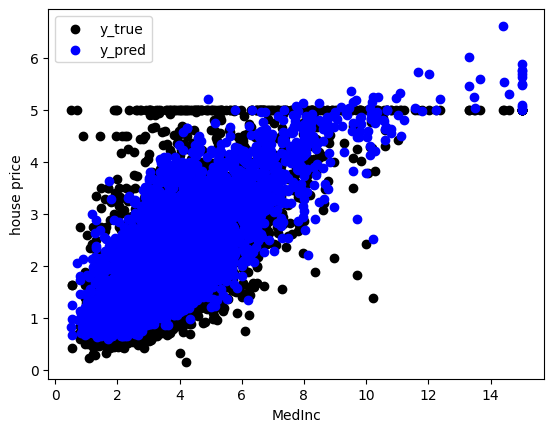

R2 score: 0.7471


In [ ]:
mse_on_test = model.evaluate(X_test, y_test)
print('The mean squared error on the test data:', mse_on_test)

y_test_pred = model.predict(X_test)

# Plot our predictions
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_test_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_test_pred)))

# 2. Classification with Neural Networks

Above we were using a Neural network to solve a regression problem. The process is very similar for classification problems, but there are some important distinctions we need to consider.

## 2.1 Data preparation


As with the regression case, all of this should be quite familliar, and in this case we will be using the breast cancer data for our classification task.

In [ ]:
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Display the dataset
Xy_pd = pd.concat([X_pd, y_pd], axis=1)
display(Xy_pd)

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
#I'm going to just take a few columns, otherwise the problem is too easy!
X_raw =  X_raw[:,0:2]
y = y_pd.to_numpy()

# Split the data into training/test data
# While we have 569 pairs of a feature and target, we use 20% only for the test, not for training and validation.
# `shuffle=True` for non-time series case. You should set `shuffle=False` to avoid future data being contaminated in the training data.
X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)



,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


Confirm the shape of the feature matrix:

While it is always a good idea to check the dimensions of your data, this is particularly important when defining a neural network in `tensorflow.keras` as we need to know the shape (dimension) of the input (feature).

In [ ]:
print('The shape of `X_train`:', X_train.shape)
print('The shape of `X_valid`:', X_valid.shape)
print('The shape of `X_test`:', X_test.shape)

The shape of `X_train`: (341, 2)
The shape of `X_valid`: (114, 2)
The shape of `X_test`: (114, 2)


The above results show that, for example, we have 341 data points in the training data, and the features for each data point is 30-dimensional.

## 2.2 Create a neural network model.
For classification, we define a discriminant function, which output a real value. This is because the loss function is defined on the output of the discriminant function, not of the hypothesis function, which outputs the target value.

The activation function is very important for our output layer in classification. You can just use a `linear` identify function, but you will have to manually do something to this output to make it work for classification. Generally for binary classification `sigmoid` is uses (as it gives a value between 0 and 1) and for multi class classification `softmax` is used (as it gives a probability for each class).



In [ ]:
# Define the `Dense` layer.
# The output dimension is 1, so we specify `units=1`.
# lets use relu for the dense layer activation this time
# The as we are performing binary classification, we specify `activation=sigmoid`.
dense_layer_1 = Dense(units=10, activation=relu)
output_layer = Dense(units=1, activation=sigmoid)

# Define the "virtual" input
input = Input(shape=X_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = output_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='logistic_regression')

# Output the summary of the model.
model.summary()



Model: "logistic_regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 10)                30        
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##2.3 Train the model

### 2.3.1 "Compile" the model: specifying a loss function, metrics and an optimizer.
Since logistic regression's loss function is the cross entropy, we create a `tensorflow.keras.losses.BinaryCrossentropy` instance and specify it as a `loss` argument of the `compile` method of the `Model` instance.
The binary cross entropy loss is defined as follows:
$$
\log (1 + \exp(- y \cdot \eta)),
$$
where $y$ is the true target value converted to either 0 or 1 and $\eta$ is the output of the discriminant function.

Also, since we may also wish to observe evaluation metrics different from the loss function in classification, such as the accuracy score, we can specify metrics in the `compile` method. Specifically, we can input a list or tuple of instances of classes in the `tensorflow.keras.metrics` module. In the following cell, we create a `tensorflow.keras.metrics.BinaryAccuracy` instance and specify a list containing the `BinaryAccuracy` instance as a `metrics` argument of the `compile` method of the `Model` instance.

For other metrics, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).

In [ ]:
# Compile the model by specifying the optimization algorithm and the loss function.
# Here, we specify the vanilla stochastic gradient descent
# (a `tensorflow.keras.optimizers.SGD` instance) as an optimizer,
# and the binary cross entropy function (a `BinaryCrossentropy` instance)
# as a loss function.

# If we want to observe metrics other than the loss function we specified,
# we can also specify the metrics in the `metrics` parameter
# in the `compile` method.

sgd = SGD(learning_rate=0.01)
ce = BinaryCrossentropy()
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])


### 2.3.2 "Fit" the model to the training data: Optimizing the parameters.
In `tensorflow.keras`, we specify a class weight when we fit the model. Here, we have to specify the weight manually. Specifically, we create a Python dictionary such that keys are the class labels and values indicate the class weight. Revise Lecture 06 for the class weight.

Epoch 1/50
4/4 [==============================] - 1s 57ms/step - loss: 0.8945 - binary_accuracy: 0.2962 - val_loss: 0.8750 - val_binary_accuracy: 0.2807
Epoch 2/50
4/4 [==============================] - 0s 12ms/step - loss: 0.8749 - binary_accuracy: 0.2933 - val_loss: 0.8592 - val_binary_accuracy: 0.2719
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 0.8570 - binary_accuracy: 0.2903 - val_loss: 0.8444 - val_binary_accuracy: 0.2982
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 0.8402 - binary_accuracy: 0.2639 - val_loss: 0.8303 - val_binary_accuracy: 0.2982
Epoch 5/50
4/4 [==============================] - 0s 17ms/step - loss: 0.8242 - binary_accuracy: 0.2786 - val_loss: 0.8170 - val_binary_accuracy: 0.3070
Epoch 6/50
4/4 [==============================] - 0s 20ms/step - loss: 0.8090 - binary_accuracy: 0.2786 - val_loss: 0.8042 - val_binary_accuracy: 0.3158
Epoch 7/50
4/4 [==============================] - 0s 18ms/step - loss: 0.7946 - bi

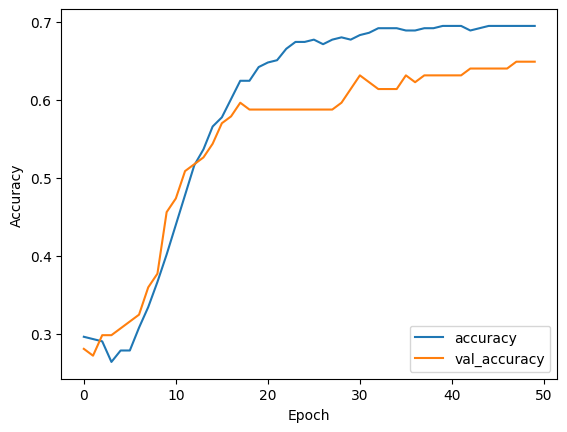

In [ ]:
# Train the model.
# `epochs` determines the number of epochs.
# `batch_size` determines the batch_size.

history = model.fit(X_train, y_train, batch_size=100, epochs=50, validation_data=(X_valid, y_valid))


# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

You can see that each epoch contains 4 mini batches. `loss` and `val_loss` show the loss function being used (the Binary Cross Entropy) on the training data and the validation data, but now we can also see our chosen accuracy metric for our model.

## 2.4 Evaluation of the NN model
we can calculate the loss and score at the same time using the `evaluate` method of the `Model` instance.

In [ ]:
ce_test, acc_test = model.evaluate(X_test, y_test)
print('The cross entropy loss on the test data:', ce_test)
print('The accuracy on the test data:', acc_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.5488 - binary_accuracy: 0.6754
The cross entropy loss on the test data: 0.5487856864929199
The accuracy on the test data: 0.6754385828971863


This seems to be less accurate than our previous model outputs may lead us to expect, so possibly some overfitting is occuring, but we will come to that shortly.

We can make a prediction using the `predict` method just as we did in the `sklearn` cases.

Although our objective is classification, the `tensorflow.keras` model itself does not distinguish classification and regression. Hence, the outputs using the `predict` method is that of the discriminant function. For this reason, we will get a sequence of real values.

In [ ]:
y_test_logit = model.predict(X_test)
print(y_test_logit[:10]) # just show you the first 10 to not spam you

4/4 [==============================] - 0s 3ms/step
[[0.57042915]
 [0.44894803]
 [0.6973872 ]
 [0.64182246]
 [0.67299986]
 [0.6979255 ]
 [0.49426585]
 [0.6811368 ]
 [0.41086203]
 [0.7765319 ]]


We can convert the above results to binary prediction by thresholding at 0.5.

In [ ]:
y_test_pred = (y_test_logit > 0.5).astype(int)
print(y_test_pred[:10])

[[1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]]


Finally, let's plot our outputs and look at our confusion matrix to further explore how well our model performed.

The accuracy on the test data with the selected hyperparameter: 0.6754385964912281
The F1 score on the test data with the selected hyperparameter: 0.7581699346405228
Precision on test data: 0.6744186046511628
Recall on test data: 0.8656716417910447


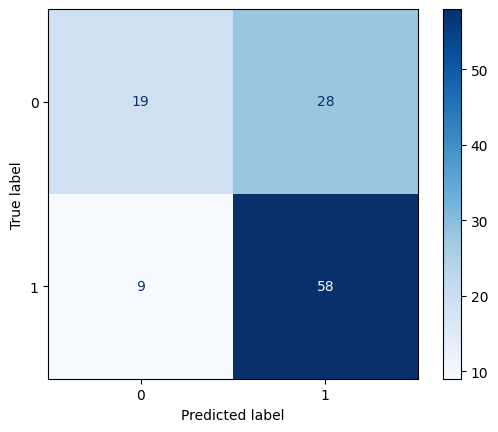

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)

acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(y_test, y_test_pred, pos_label=1)
print('Precision on test data:', pre_test)
reca_test = recall_score(y_test, y_test_pred, pos_label=1)
print('Recall on test data:', reca_test)

## 2.5 Class imbalances

As covered in previous weeks, when performing classification, the number of instances in each class can have an impact on how well the model predicts each class.

For the breast cancer dataset, the class imbalance isn't too bad, however we do have a slight imbalance that may be impacting our model. The first part of creating our model is the same:




In [ ]:
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
X_raw =  X_raw[:,0:2]
y = y_pd.to_numpy()

# Split the data into training/test data
# While we have 569 pairs of a feature and target, we use 20% only for the test, not for training and validation.
# `shuffle=True` for non-time series case. You should set `shuffle=False` to avoid future data being contaminated in the training data.
X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)


# Define the `Dense` layers.
dense_layer_1 = Dense(units=10, activation=relu)
output_layer = Dense(units=1, activation=sigmoid)

# Define the "virtual" input
input = Input(shape=X_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = output_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='logistic_regression_balanced')

# Output the summary of the model.
model.summary()


sgd = SGD(learning_rate=0.01)
ce = BinaryCrossentropy()
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])

Model: "logistic_regression_balanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 10)                30        
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


What we change is at the 'fitting' stage - in `tensorflow.keras`, we can specify a class weight when we fit the model.

Here, we have to specify the weight manually. Specifically, we create a Python dictionary such that keys are the class labels and values indicate the class weight.

Epoch 1/50
4/4 [==============================] - 1s 52ms/step - loss: 0.7143 - binary_accuracy: 0.2874 - val_loss: 0.7362 - val_binary_accuracy: 0.3333
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 0.7066 - binary_accuracy: 0.3050 - val_loss: 0.7292 - val_binary_accuracy: 0.3684
Epoch 3/50
4/4 [==============================] - 0s 12ms/step - loss: 0.6992 - binary_accuracy: 0.3343 - val_loss: 0.7222 - val_binary_accuracy: 0.3772
Epoch 4/50
4/4 [==============================] - 0s 17ms/step - loss: 0.6917 - binary_accuracy: 0.3754 - val_loss: 0.7156 - val_binary_accuracy: 0.3947
Epoch 5/50
4/4 [==============================] - 0s 17ms/step - loss: 0.6844 - binary_accuracy: 0.4223 - val_loss: 0.7089 - val_binary_accuracy: 0.4386
Epoch 6/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6770 - binary_accuracy: 0.4663 - val_loss: 0.7024 - val_binary_accuracy: 0.4474
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 0.6699 - bi

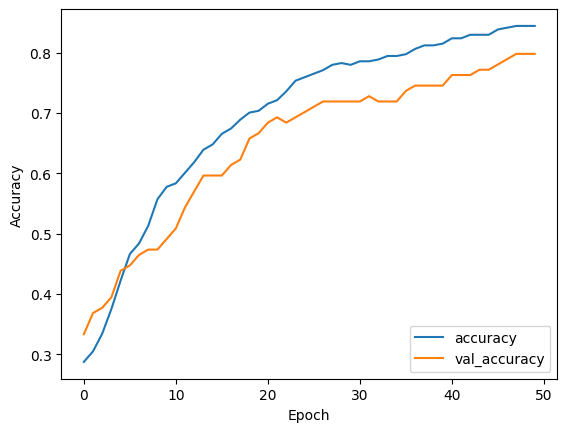

In [ ]:
# Train the model.
# `epochs` determines the number of epochs.
# `batch_size` determines the batch_size.

m = {}
m[0] = np.sum((y_train == 0).astype(int)) # Count how many times `0` appears in the target matrix.
m[1] = np.sum((y_train == 1).astype(int)) # Count how many times `1` appears in the target matrix.
m_total = m[0] + m[1]
class_weight = {0: m_total / (2.0 * m[0]), 1: m_total / (2.0 * m[1])}

history = model.fit(X_train, y_train, batch_size=100, epochs=50, validation_data=(X_valid, y_valid), class_weight=class_weight)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

As the `class_weight` is not supported in the `evaluate` method for tensorflow if you want to measure this metric we can use `sklearn` functions.

In [ ]:
y_test_logit = model.predict(X_test)
y_test_pred = (y_test_logit > 0.5).astype(int)
bacc = balanced_accuracy_score(y_test, y_test_pred)
print('The balanced accuracy score on the test data:', bacc)

4/4 [==============================] - 0s 3ms/step
The balanced accuracy score on the test data: 0.8742457923150206


But let's also use the same evaluation metrics we used for the unbalanced model. As we can see, by some metrics it performs better (precision), but by other worse. So as always with regression whether this makes for a better solution depends on what the model is being used for. Accounting for class weights can help, but don't automatically make your models better in all cases!

The accuracy on the test data with the selected hyperparameter: 0.8596491228070176
The F1 score on the test data with the selected hyperparameter: 0.8688524590163933
Precision on test data: 0.9636363636363636
Recall on test data: 0.7910447761194029


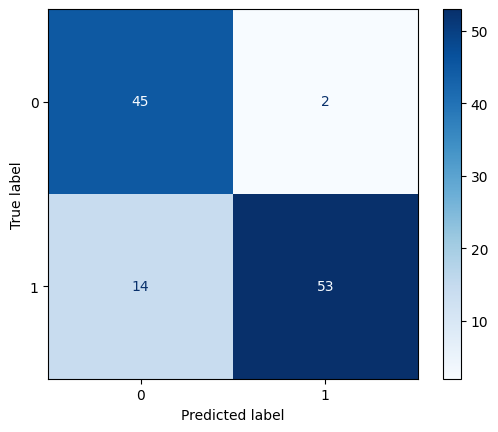

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)

acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(y_test, y_test_pred, pos_label=1)
print('Precision on test data:', pre_test)
reca_test = recall_score(y_test, y_test_pred, pos_label=1)
print('Recall on test data:', reca_test)

##2.6 Exercise 2

So far we have just been using a neural network with one layer and not many units. Add more layers, units and features to our NN and see if we can obtain even greater accuracy. I was able to get an f1 score of 0.97, can you beat me? (Though do remember, there is a stochastic element to the training of Neural Networks, so you may not always get the same accuracy running the same model multiple times from the start. Still, if your model is well constructed they should be comparable)

Model: "Exercise_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_13 (Dense)            (None, 50)                1550      
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 4151 (16.21 KB)
Trainable params: 4151 (16.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 1s 63ms/step - loss: 1.6224 - binary_accuracy: 0.5513 - val_loss: 1.5788 - val_binary_accuracy: 0.5526


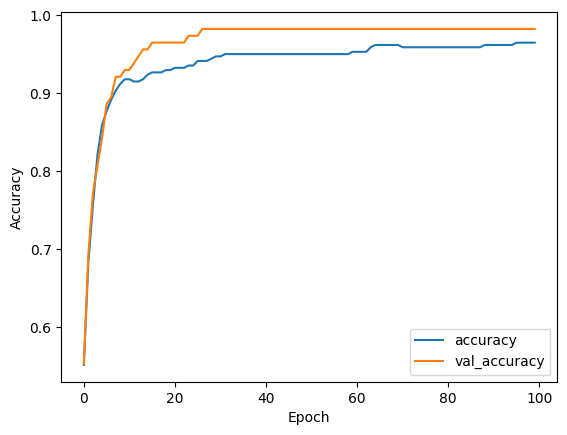

4/4 [==============================] - 0s 3ms/step


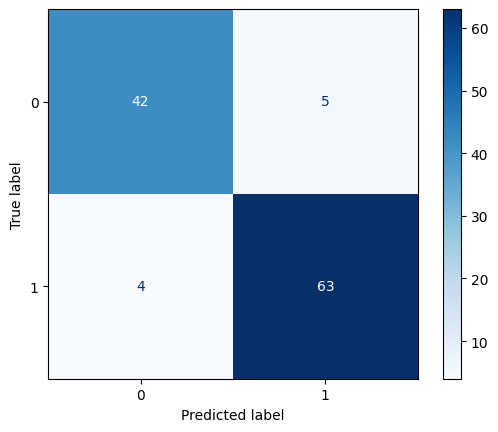

The accuracy on the test data with the selected hyperparameter: 0.9210526315789473
The F1 score on the test data with the selected hyperparameter: 0.9333333333333335
Precision on test data: 0.9264705882352942
Recall on test data: 0.9264705882352942


In [ ]:
##############################################################
# Your code here
##############################################################

##############################################################
# Your code here
##############################################################
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
y = y_pd.to_numpy()

# Split the data into training/test data
X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

# Define the regularizer.
alpha = 0.01
kernel_regularizer = L2(l2=alpha)

# Define the `Dense` layer.
dense_layer_1 = Dense(units=50, activation=relu, kernel_regularizer=kernel_regularizer)
dense_layer_2 = Dense(units=50, activation=relu, kernel_regularizer=kernel_regularizer)
out_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)

# Define the "virtual" input
input = Input(shape=X_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = dense_layer_2(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Exercise_3')

# Output the summary of the model.
model.summary()

sgd = SGD(learning_rate=0.01)
ce = BinaryCrossentropy(from_logits=False)
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])

# Train the model.
m = {}
m[0] = np.sum((y_train == 0).astype(int)) # Count how many times `0` appears in the target matrix.
m[1] = np.sum((y_train == 1).astype(int)) # Count how many times `1` appears in the target matrix.
m_total = m[0] + m[1]
class_weight = {0: m_total / (2.0 * m[0]), 1: m_total / (2.0 * m[1])}

history = model.fit(X_train, y_train, batch_size=100, epochs=100, validation_data=(X_valid, y_valid), class_weight=class_weight)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

y_test_logit = model.predict(X_test)
y_test_pred = (y_test_logit > 0.5).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(y_test, y_test_pred, pos_label=1)
print('Precision on test data:', pre_test)
reca_test = precision_score(y_test, y_test_pred, pos_label=1)
print('Recall on test data:', reca_test)

## 2.7 Multi-class classification


Of course, as we learnt in previous weeks, we can also have classification problems with multiple classes. The implementation to solve these using Neural Networks isn't massively different, but as always has some differences we need to keep in mind.

We will start by loading and scaling the Iris dataset as usual:

In [ ]:

# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
y = y_pd.to_numpy()

# Split the data into training/test data
X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

Constructing the model architecture is mostly the same - but now we need to use the `softmax` activation function. For softmax to work properly we need to also change the output units to be the number of classes in our dataset (`3` in this case). This means the model will actually be outputting three target columns containing the probabilities for each class. We'll talk about how we deal with this in a moment.

In [ ]:
# Define the `Dense` layer.
dense_layer_1 = Dense(units=50, activation=relu)
dense_layer_2 = Dense(units=50, activation=relu)
out_layer = Dense(units=3, activation=softmax)

# Define the "virtual" input
input = Input(shape=X_raw.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = dense_layer_2(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Multi_class_Classification')

# Output the summary of the model.
model.summary()


Model: "Multi_class_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_16 (Dense)            (None, 50)                250       
                                                                 
 dense_17 (Dense)            (None, 50)                2550      
                                                                 
 dense_18 (Dense)            (None, 3)                 153       
                                                                 
Total params: 2953 (11.54 KB)
Trainable params: 2953 (11.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


When compiling our model, any optimiser still works, but we now need to think what loss functions and accuracy metrics to use.

Because we are outputting columns we have a complication, as our dataset has the ratget in a single columns. One option would be to one hot encode our target column, but tensorflow can also handle this mismatch is we use these `Sparse` loss/accuracy functions which know how to force the outputted data into the correct format for comparison with a single column target.

Epoch 1/100
5/5 [==============================] - 1s 41ms/step - loss: 1.0675 - sparse_categorical_accuracy: 0.3444 - val_loss: 1.0461 - val_sparse_categorical_accuracy: 0.3333
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 1.0205 - sparse_categorical_accuracy: 0.4111 - val_loss: 0.9978 - val_sparse_categorical_accuracy: 0.4333
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 0.9763 - sparse_categorical_accuracy: 0.4444 - val_loss: 0.9551 - val_sparse_categorical_accuracy: 0.5667
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 0.9358 - sparse_categorical_accuracy: 0.5556 - val_loss: 0.9163 - val_sparse_categorical_accuracy: 0.7000
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 0.8986 - sparse_categorical_accuracy: 0.6556 - val_loss: 0.8822 - val_sparse_categorical_accuracy: 0.8000
Epoch 6/100
5/5 [==============================] - 0s 14ms/step - loss: 0.8649 - sparse_categorical_accuracy: 

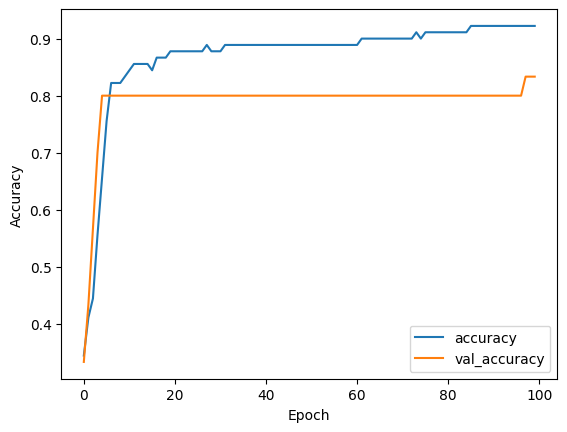

In [ ]:
# Import 'Sparse' losses/metrics
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# COmpile the model
sgd = SGD(learning_rate=0.01)
ce = SparseCategoricalCrossentropy()
acc = SparseCategoricalAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])

# Train the model.
history = model.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_valid, y_valid))

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Now we can make predictions with our model. See below that our predictions still give three columns:

In [ ]:
y_test_logit = model.predict(X_test)
print(y_test_logit)

1/1 [==============================] - 0s 44ms/step
[[0.01300274 0.12546562 0.8615317 ]
 [0.01478949 0.9130107  0.0721998 ]
 [0.990225   0.00864241 0.00113265]
 [0.0032253  0.10601211 0.89076257]
 [0.98111147 0.01591305 0.00297554]
 [0.00587519 0.03913319 0.9549916 ]
 [0.9844009  0.01291404 0.00268508]
 [0.0325056  0.36769304 0.5998014 ]
 [0.02113044 0.45847395 0.5203956 ]
 [0.05289716 0.6913699  0.25573292]
 [0.01658776 0.517579   0.46583322]
 [0.05446256 0.38191807 0.5636193 ]
 [0.0397193  0.643241   0.3170397 ]
 [0.02687133 0.44758075 0.5255479 ]
 [0.04119112 0.49105483 0.46775407]
 [0.98943526 0.00894736 0.00161744]
 [0.04793663 0.46666667 0.48539668]
 [0.04054174 0.8222982  0.13716005]
 [0.9610167  0.03403058 0.00495273]
 [0.98530906 0.01236831 0.00232265]
 [0.03049143 0.28699076 0.6825178 ]
 [0.08680122 0.47428915 0.43890968]
 [0.97693366 0.01913361 0.00393269]
 [0.96789974 0.0287006  0.00339968]
 [0.02285242 0.2857659  0.69138175]
 [0.99300367 0.00584576 0.00115055]
 [0.97719157

We can use the `argmax` function to force this into a single column selecting the highest probability class:

In [ ]:
y_test_pred = np.argmax(y_test_logit, axis=1)
print(y_test_pred)

[2 1 0 2 0 2 0 2 2 1 1 2 1 2 1 0 2 1 0 0 2 1 0 0 2 0 0 1 1 0]


This allows us to use this prediction in our confusion matrix and using our metrics - remember that other than accuracy they generally now need to be averaged ('macro' - for equal weighing of classes and 'weighted' to take into account class imbalance). to give us a good idea of the overall accuracy.

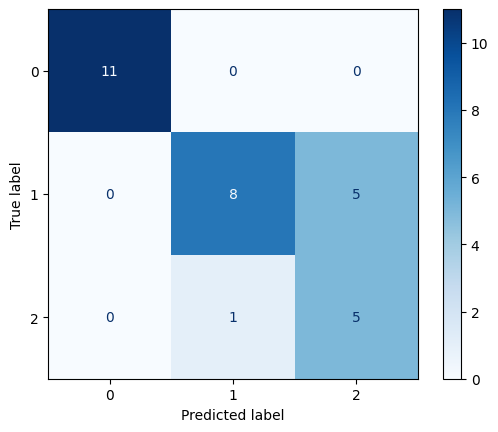

The accuracy on the test data with the selected hyperparameter: 0.8
The F1 score on the test data with the selected hyperparameter: 0.7840909090909092
Precision on test data: 0.7962962962962963
Recall on test data: 0.8162393162393163


In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='macro')
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(y_test, y_test_pred, average='macro')
print('Precision on test data:', pre_test)
reca_test = recall_score(y_test, y_test_pred, average='macro')
print('Recall on test data:', reca_test)

# 3. Parametric testing with Neural Networks

When constructing a Neural Network there are a number of things you may want to experiment with, including, but not limited to:

1. Type of preprocessing used (Standardization vs Normalization, different encoding, missing data imputation, etc)  
2. Changing the number of hidden units in the network
3. Changing the number of layers in the network
4. Using different activation functions in the hidden layers (Relu is a good default choice, but others may work better)
5. Compiling the model with different optimizers (Adam is a safe choice, but there are other options)
6. Changing the learning rates
7. Train the model for more epochs
8. Changing the batch sizes
9. Trying different accuracy metrics
10. Accounting for class imbalances

When testing these, you need to make sure you go about it systematically and keep records of what improves or harms your model accuracy - don't just change things ad hoc and hope you eventually hit on the perfect model randomly!

For some hyperparameters in particular (learning rate, regularisation strength, batch size, number of layers, number of units, etc) it is beneficial to tune these to obtain the best network.

While we may want to experiment with some of these manually, in general the smart way to do things involves automating the process as much as possible. In past week's you have been shown how to do this for the regularisation strength, so let's do it again here for a Neural Network!


In [ ]:
# First we can define some functions to create our model then compile and train it
# This should make our lives a bit easier and the code clearer when it comes to finding the paramaters
# this is a very simple one just for varying the number of hidden units, but using loops you could make something allowing much more complxity.
def create_model(n_hidden=50):
    dense_layer_1 = Dense(units=n_hidden, activation=relu)
    dense_layer_2 = Dense(units=n_hidden, activation=relu)
    out_layer = Dense(units=1, activation=sigmoid)
    input=Input(shape=X_train.shape[1:])

    output = dense_layer_1(input)
    output = dense_layer_2(output)
    output = out_layer(output)
    model = Model(inputs=[input], outputs=[output], name='ParaTest')
    return model

def model_compile_and_training(X_train, y_train, X_valid, y_valid, learning_rate= 0.01, n_epochs= 10, batch_size=100):
    model.compile(optimizer=SGD(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid, y_valid), verbose=0) # Verbose=0 suppresses the output
    return model, history

Now we can run the automated loop (make sure you give enough training time for a fair comparison - I have chosen a relatively small number of epochs just for this quick example, but I would usually expect you to do at least a few 100 to give all models a fair chance to converge):

4/4 [==============================] - 0s 3ms/step
The best number of hidden units: 100


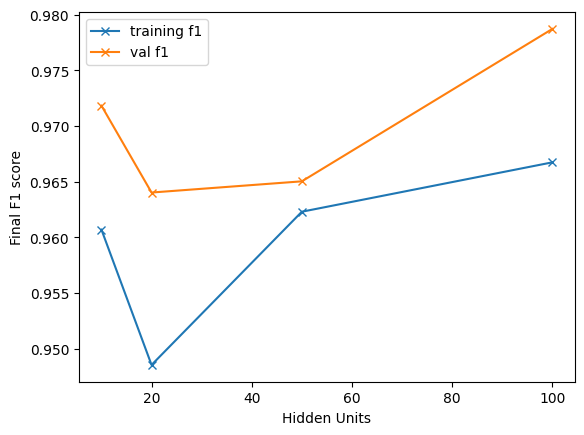

In [ ]:
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Convert the target column vector `y_pd` into 2-dimensional array (a `pd.DataFrame` instance)
y_pd = y_pd.to_frame()

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
y = y_pd.to_numpy()

# Split the data into training/test data
X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

HUs = [10, 20, 50, 100]
train_array = np.full([len(HUs)], np.nan)
valid_array = np.full([len(HUs)], np.nan)
f1_train_array = np.full([len(HUs)], np.nan)
f1_valid_array = np.full([len(HUs)], np.nan)

for HU_index, HU in enumerate(HUs):
  # Run our two functions to create and compile the model
  model = create_model(n_hidden=HU)
  model_compile_and_training(X_train, y_train, X_valid, y_valid, learning_rate= 0.01, n_epochs= 50, batch_size=100)

  y_pred_train = model.predict(X_train)
  y_pred_train = (y_pred_train > 0.5).astype(int)

  train_array[HU_index] = accuracy_score(y_train, y_pred_train)
  f1_train_array[HU_index] = f1_score(y_train, y_pred_train, pos_label=1)

  y_pred_valid = model.predict(X_valid)
  y_pred_valid = (y_pred_valid > 0.5).astype(int)

  valid_array[HU_index] = accuracy_score(y_valid, y_pred_valid)
  f1_valid_array[HU_index] = f1_score(y_valid, y_pred_valid, pos_label=1)


# Select our best performing C (biggest f1)
best_HU_index = np.argmax(f1_valid_array)
best_HU= HUs[best_HU_index]
print('The best number of hidden units:', best_HU)

# plot the results
plt.figure()
plt.plot(HUs, f1_train_array, '-x', label='training f1')
plt.plot(HUs, f1_valid_array, '-x', label= 'val f1')
plt.xlabel('Hidden Units')
plt.ylabel('Final F1 score')
plt.legend()

## 3.1 Adressing Overfitting

As explained in the lecture, Neural Networks are just as prone to overfitting as other complex models.

There are various manual approaches you can take such as:
*   Removing Neurons and/or layers from the model (lowering complexity)
*   Obtaining more training data
*   Removing unneeded features

But as with our linear models, manually experimenting with these things can be quite slow. While simplifying needlessly complex models and data is never a bad thing, there are a selection of automatic techniques which are quick and easy to implement that should help with any overfitting.

###3.1.1 Regularisation


As we discussed in previous lectures, we need regularisation to make the optimization stable as well as to avoid overfitting which can be useful for both regression and classification models.

You can integrate regularisation directly into your dense layers, and this can also apply for Regression problems where it performs the same purpose as it did in general models where it adds a term to the cost function that will encourage the model to minimise the magnitude of edge weights (parameters) being used by the model. We can again specify L1 (Lasso) regularisation and L2 (Ridge) regression. Of course, if you use regularisation you need to be careful with picking you hyperparameter $\alpha$, otherwise you could either end up underfitting if it is too high and the regularisation will have no effect if it is too small.

For other regularizers, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers).

See below for an example of the code you need to include in your network to add regularisation:



In [ ]:
# Define the regularizer.
alpha = 0.001
#Pick one of the Regularisation methods
kernel_regularizer = L1(l1=alpha) #Lasso
kernel_regularizer = L2(l2=alpha) #Ridge
layer = Dense(units=10, activation=relu, kernel_regularizer=kernel_regularizer)

###3.1.2 Dropout Layers

In order to simulate training multiple models in parallel and combining them, adding dropout layers randomly turn off nodes in the network with every epoch to make the Network more robust to overfitting particular nodes/edges. The proportion of dropouts and even the number of dropout nodes are both other hyperparameters that need considering when constructing your model (if you decide to include dropout). A single dropout layer may not be enough in truly complicated networks!

See below for an example of a basic model with a dropout layer added. Often you will have dropout layers to correspond with every dense layer, but as always in ML there are many different strategies used.

Note: this is quite a simple network and having dropout nodes is probably a bit overkill, though adding dropout to your layers is usually a good thing as it should make the network more robust.


In [ ]:
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
y_pd = y_pd.to_frame()

X_raw = X_pd.to_numpy()
X_raw=X_raw[0:1000,0:2]
y = y_pd.to_numpy()
y=y[0:1000]

X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

first_layer = Dense(units=128*4, activation=relu)
##############################
# Set proportion of nodes to deactivate with every training iteration (20% in this case)
second_layer = Dropout(0.2)
##############################
third_layer = Dense(units=128*4, activation=relu)
forth_layer = Dense(units=128*4, activation=relu)
fifth_layer = Dense(units=128*4, activation=relu)
out_layer = Dense(units=1, activation=linear)

input = Input(shape=X_train.shape[1:])
output = first_layer(input)
output = second_layer(output)
output = third_layer(output)
output = forth_layer(output)
output = fifth_layer(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Dropout')
model.summary()

Model: "Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_32 (Dense)            (None, 512)               1536      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 dense_36 (Dense)            (None, 1)                 513 

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 5.0680 - val_loss: 4.5732
Epoch 2/100
1/1 [==============================] - 0s 50ms/step - loss: 4.5975 - val_loss: 4.1598
Epoch 3/100
1/1 [==============================] - 0s 53ms/step - loss: 4.1751 - val_loss: 3.7786
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 3.7867 - val_loss: 3.4227
Epoch 5/100
1/1 [==============================] - 0s 51ms/step - loss: 3.4292 - val_loss: 3.0875
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 3.0793 - val_loss: 2.7703
Epoch 7/100
1/1 [==============================] - 0s 51ms/step - loss: 2.7523 - val_loss: 2.4706
Epoch 8/100
1/1 [==============================] - 0s 45ms/step - loss: 2.4373 - val_loss: 2.1887
Epoch 9/100
1/1 [==============================] - 0s 50ms/step - loss: 2.1465 - val_loss: 1.9255
Epoch 10/100
1/1 [==============================] - 0s 44ms/step - loss: 1.8791 - val_loss: 1.6840
Epoch 11/100
1/1 [===

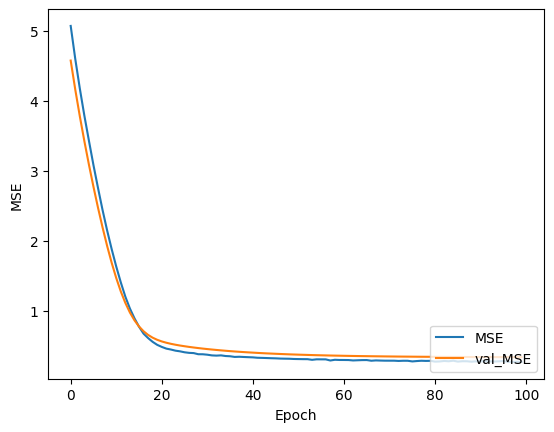

In [ ]:
# Compile the model by specifying the optimization algorithm and the loss function.
sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

# Train the model.
history = model.fit(X_train, y_train, batch_size=1000, epochs=100, validation_data=(X_valid, y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')

###3.1.3 Early Stopping

Early stopping simply monitors the validation data, and if it identifies that the validation accuracy/error is deteriorating then it will stop training the model further. However, you do want to leave some leeway as fitting Neural Networks can be a bit stochastic, so you don't want to immediately stop the first time the validation loss increases. This tolerance is called the `patience` and is a hyperparamter that says how many iterations it will tolerate with a loss above the best observed value. You may need to experiment with so that you can hit the sweet spot of not overfitting but also not ending your training prematurely.

This can simply be done by making a callback instance and defining this when fitting the model, there is an example on a simple model below (callback information in the second cell)

In [ ]:
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
y_pd = y_pd.to_frame()

X_raw = X_pd.to_numpy()
X_raw=X_raw[0:500,0:2]
y = y_pd.to_numpy()
y=y[0:500]

X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

first_layer = Dense(units=128*4, activation=relu)
second_layer = Dense(units=128*4, activation=relu)
third_layer = Dense(units=128*4, activation=relu)
forth_layer = Dense(units=128*4, activation=relu)
fifth_layer = Dense(units=128*4, activation=relu)
out_layer = Dense(units=1, activation=linear)

input = Input(shape=X_train.shape[1:])
output = first_layer(input)
output = second_layer(output)
output = third_layer(output)
output = forth_layer(output)
output = fifth_layer(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Early_Stop')
model.summary()

Model: "Early_Stop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_37 (Dense)            (None, 512)               1536      
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dense_39 (Dense)            (None, 512)               262656    
                                                                 
 dense_40 (Dense)            (None, 512)               262656    
                                                                 
 dense_41 (Dense)            (None, 512)               262656    
                                                                 
 dense_42 (Dense)            (None, 1)                 5

Epoch 1/100
1/1 [==============================] - 1s 958ms/step - loss: 4.5259 - val_loss: 1.8630
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 1.7931 - val_loss: 0.7036
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 0.6676 - val_loss: 0.5825
Epoch 4/100
1/1 [==============================] - 0s 30ms/step - loss: 0.5579 - val_loss: 0.5025
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 0.4896 - val_loss: 0.4542
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 0.4549 - val_loss: 0.4305
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 0.4389 - val_loss: 0.4119
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 0.4322 - val_loss: 0.4114
Epoch 9/100
1/1 [==============================] - 0s 43ms/step - loss: 0.4304 - val_loss: 0.3992
Epoch 10/100
1/1 [==============================] - 0s 32ms/step - loss: 0.4336 - val_loss: 0.4319
Epoch 11/100
1/1 [

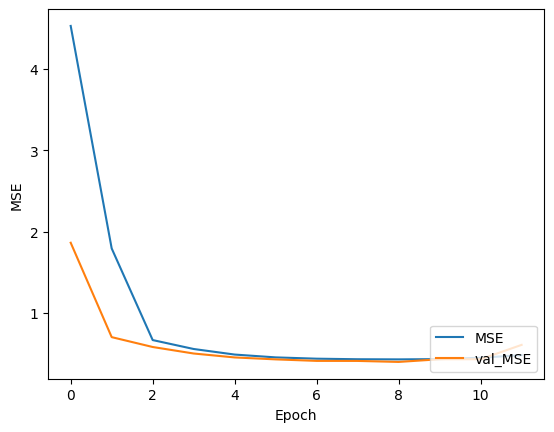

In [ ]:
# Compile the model by specifying the optimization algorithm and the loss function.
sgd = SGD(learning_rate=0.1)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

###################################################################################
# Early Stopping
# Choose what metric to monitor (validation accuracy a good metric for overfitting in regression)
# Patience is how many iterations with a loss above the lowest observed value will be tolerated
callback = EarlyStopping(monitor='val_loss', patience=3)
####################################################################################

# Train the model.
history = model.fit(X_train, y_train, batch_size=1000, epochs=100, validation_data=(X_valid, y_valid), verbose=1, callbacks=[callback])

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')

##3.2 Continuing training



One thing you may not have noticed is that you can continue training your model without having to start from scratch each time. You can do this simply by rerunning (you can change things like the `epoch` so you don't have to run it under exactly the same conditions):

`history = model.fit(....)`

which will take the existing model you have already trained and continue training from there. This can be useful if you think your model is nearly converged and you just want to run it for a little longer and/or you don't want to lose the time you spent training previously.

Of course, you may not always want to do this, and you can 'reset' your model weights by rerunning the code that defines the model object:

`model = Model(...)`


## 3.3 Saving your model

Sometimes it can take a long time to train a model that uses big data or is very complex, so obviously you don't want to lose this progress, but one issue with using Colab is that it clears out your runtime every time you stop using it.

For that reason, you may want to save the trained weights of your model so you can come back to it later and improve it or use it for making predictions on other data.

If you are interested in learning more about this, I would direct you to [TensorFLow's tutorial on the topic.](https://www.tensorflow.org/tutorials/keras/save_and_load)

I won't go into this in any further detail here, as it should not be an issue for your coursework or any of the tutorials. But I thought it would be useful to let you know this is an option in case it is relevant to you later in your MSC project or in your work.



## 3.4 Exercise 3


Try using this rough framework to experiment with a few different parameters to optimise the breast cancer dataset


1.   Try training the models for more epochs when calculating the regularisation weight.
2.   Try altering the learning rate.
3.   Try testing different number of hidden units.
4.   Change the number of layers and try testing some of the above again, do you get different results?



In [ ]:
##############################################################
# Your code here
##############################################################

##############################################################
# Your code here
##############################################################

# First we can define some functions to create our model then compile and train it
# This should make our lives a bit easier and the code clearer when it comes to finding the paramaters
def create_model(n_hidden=50):
    dense_layer_1 = Dense(units=n_hidden, activation=relu)
    dense_layer_2 = Dense(units=n_hidden, activation=relu)
    out_layer = Dense(units=1, activation=sigmoid)
    input=Input(shape=X_train.shape[1:])
    # Note, we can stack our layers in a single line like this to save space, but this approach does make it harder adding and removing layers.
    output = out_layer(dense_layer_2(dense_layer_1(input)))
    model = Model(inputs=[input], outputs=[output], name='Exercise_3')
    return model

def model_compile_and_training(X_train, y_train, X_valid, y_valid, learning_rate= 0.01, n_epochs= 10, batch_size=100):
    model.compile(optimizer=SGD(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid, y_valid), verbose=0) # Verbose=0 suppresses the output
    return model, history

4/4 [==============================] - 0s 3ms/step
The best number of units: 100


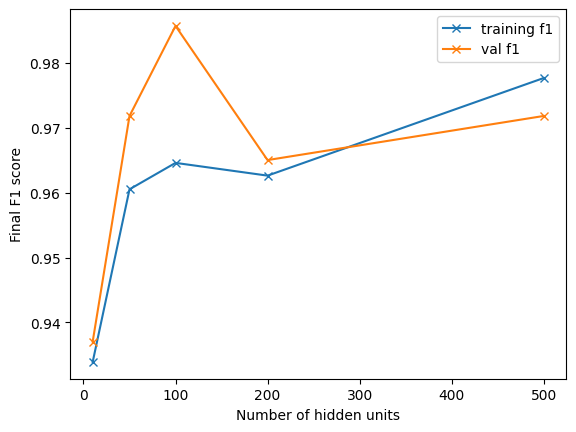

In [ ]:
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Convert the target column vector `y_pd` into 2-dimensional array (a `pd.DataFrame` instance)
y_pd = y_pd.to_frame()

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
y = y_pd.to_numpy()

# Split the data into training/test data
X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

hidden_units = [10, 50, 100, 200, 500]
train_array = np.full([len(hidden_units)], np.nan)
valid_array = np.full([len(hidden_units)], np.nan)
f1_train_array = np.full([len(hidden_units)], np.nan)
f1_valid_array = np.full([len(hidden_units)], np.nan)

for HU_index, nh in enumerate(hidden_units):
  # Run our two functions to create and compile the model
  model = create_model(n_hidden=nh)
  model_compile_and_training(X_train, y_train, X_valid, y_valid, learning_rate= 0.01, n_epochs= 50, batch_size=100)

  y_pred_train = model.predict(X_train)
  y_pred_train = (y_pred_train > 0.5).astype(int)

  train_array[HU_index] = accuracy_score(y_train, y_pred_train)
  f1_train_array[HU_index] = f1_score(y_train, y_pred_train, pos_label=1)

  y_pred_valid = model.predict(X_valid)
  y_pred_valid = (y_pred_valid > 0.5).astype(int)

  valid_array[HU_index] = accuracy_score(y_valid, y_pred_valid)
  f1_valid_array[HU_index] = f1_score(y_valid, y_pred_valid, pos_label=1)


# Select our best performing number of units (biggest f1)
best_hidden_index = np.argmax(f1_valid_array)
best_units = hidden_units[best_hidden_index]
print('The best number of units:', best_units)

# plot the results
plt.figure()
plt.plot(hidden_units, f1_train_array, '-x', label='training f1')
plt.plot(hidden_units, f1_valid_array, '-x', label= 'val f1')
plt.xlabel('Number of hidden units')
plt.ylabel('Final F1 score')
plt.legend()

In [ ]:
def create_model(reg_str=0.01,n_hidden=50):
    kernel_regularizer = L2(l2=reg_str)
    dense_layer_1 = Dense(units=n_hidden, activation=relu, kernel_regularizer=kernel_regularizer)
    dense_layer_2 = Dense(units=n_hidden, activation=relu, kernel_regularizer=kernel_regularizer)
    out_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)
    input=Input(shape=X_train.shape[1:])
    # Note, we can stack our layers in a single line like this to save space, but this approach does make it harder adding and removing layers.
    output = out_layer(dense_layer_2(dense_layer_1(input)))
    model = Model(inputs=[input], outputs=[output], name='Exercise_4')
    return model

def model_compile_and_training(X_train, y_train, X_valid, y_valid, learning_rate= 0.01, n_epochs= 10, batch_size=100):
    model.compile(optimizer=SGD(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid, y_valid), verbose=0) # Verbose=0 suppresses the output
    return model, history

##3.5 Exercise 4

Use this parametric testing approach used above to try exploring the hyperparameters for your regression problem in **Exercise 1** to obtain the best model you can. I don't have a particular 'perfect' answer in mind here, what I want you to do is experiment with many of the aspects of a neural network discussed at the start of this section to see what the best model you can obtain is. This may involve multiple passes where you change the number of layers in the model (or their activation function, or some other fundamental change) and then you can work on optimising the hyperparameters.

**Warning**: It may take some time for the parametric test to complete if you are running a model with many layers/units for potentially hundreds of epochs. It's impossible to train every permutation of model ever, all we can hope to do is advance things logically and systematically (e.g. pick an initial model structure, try tuning the hyperparameters on this model, once you have these hyperparameters you can experiment with changing the model layout. Then you may want to go back again and see if tuning the hyperparameters for this new model improves things). You also may want to try fitting a model on a subset of the data for speed, then try doing the final tunings on the full dataset once you have a model setup you are fairly happy with.

In [ ]:
##############################################################
# Your code here
##############################################################

##3.6 Exercise 5

Try using everything we've learnt to find a model that provides good results on the Wine Dataset (`sklearn.datasets.load_wine()` - a multi class classification problem). This is quite an easy dataset, so I was able to get perfect accuracy on my test data!

Model: "Multi_class_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 13)]              0         
                                                                 
 dense_94 (Dense)            (None, 50)                700       
                                                                 
 dense_95 (Dense)            (None, 50)                2550      
                                                                 
 dense_96 (Dense)            (None, 3)                 153       
                                                                 
Total params: 3403 (13.29 KB)
Trainable params: 3403 (13.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 1s 55ms/step - loss: 1.0008 - sparse_categorical_accuracy: 0.4245 - val_loss: 0.9822 - 

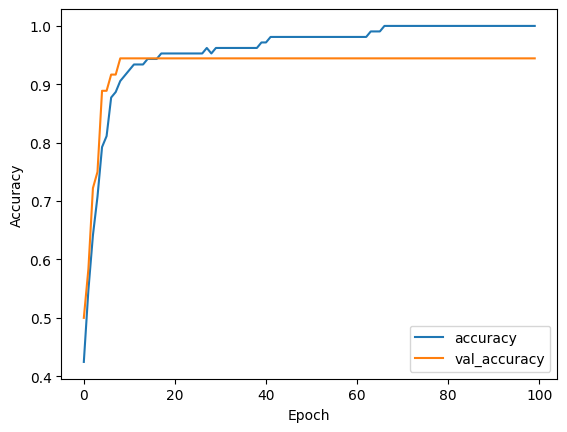

2/2 [==============================] - 0s 5ms/step


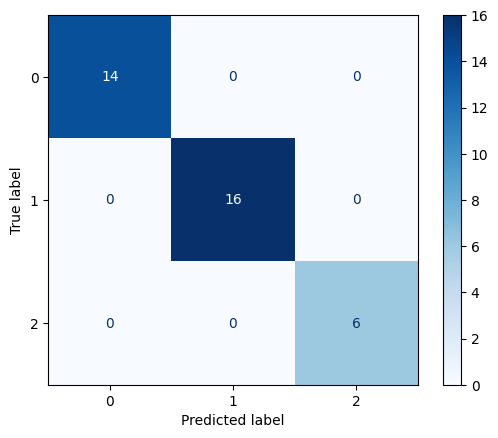

The accuracy on the test data with the selected hyperparameter: 1.0
The F1 score on the test data with the selected hyperparameter: 1.0
Precision on test data: 1.0
Recall on test data: 1.0


In [ ]:
##############################################################
# Your code here
##############################################################

#Appendix 1: Sequential Models (Bonus Exercise)

In this tutorial we have been using the *functional* (`Model`) api for creating our neural networks ([see here for documentation](https://www.tensorflow.org/guide/keras/functional/)), but this isn't the only way we can create them.

Another very common way of constructing Neural Networks is to use the `Sequential` model api ([see here for documentation](https://www.tensorflow.org/guide/keras/sequential_model)). Less common (in my experience), but you may also encounter how to make models using *subclassing*, which I won't cover here ([see here for documentation](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)).

I have chosen to use the `Model` api as I feel it offers you the best compromise between useability and being able to quite easily incorporate some more advanced functionality (such as transfer learning and multiple outputs).

However, if you just want to create a linear Neural Network from scratch, the `Sequential` api is perfectly acceptable and quite intuitive to use, so feel free to use either method for your coursework.

Below I have just implemented the first basic Neural Network we used at the start of the tutorial.

**Bonus Exercise** This model is quite bad (certainly needs more training), see if you can get to grips with the sequential API and remake whatever your solution was for *Exercise 1*. You could also try remaking one of your classification models using this approach.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 5)                 45        
                                                                 
 dense_98 (Dense)            (None, 5)                 30        
                                                                 
 dense_99 (Dense)            (None, 1)                 6         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 1s 14ms/step - loss: 4.2475 - val_loss: 2.7652
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 2.1509 - val_loss: 1.7411
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 1.5431 - val

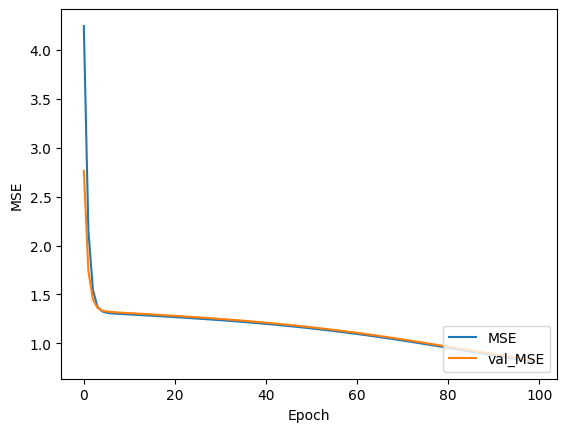

129/129 [==============================] - 0s 2ms/step - loss: 0.8146
The mean squared error on the test data: 0.8145542740821838
129/129 [==============================] - 0s 2ms/step


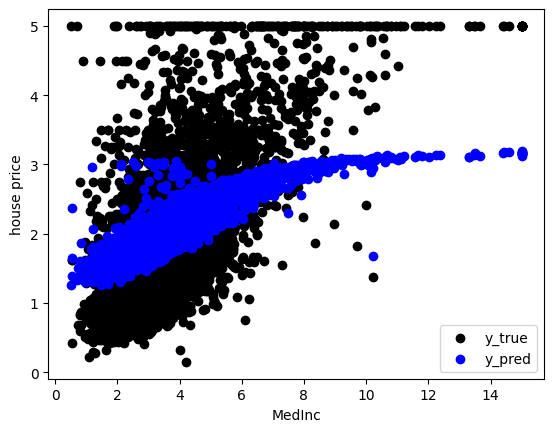

R2 score: 0.3753


In [ ]:
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
y_pd = y_pd.to_frame()

X_raw = X_pd.to_numpy()
y = y_pd.to_numpy()


X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

##################################################
# Everything else in this should be the same as our initial example
# Here we define our model first and add dense layers one at a time
# While a bit simpler to understand, this approach is less flexible and doesn't allow us to do as much as the functional api.
model = Sequential()
# Note, we don't need to define an input layer, just specidy the input dimension for the first layer.
model.add(Dense(5, input_dim=len(X_train[1]),activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='linear'))
##################################################

# Should see that this is the same as the model we made earlier in the first example.
model.summary()

sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

history = model.fit(X_train, y_train, batch_size=1000, epochs=100, validation_data=(X_valid, y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

mse_on_test = model.evaluate(X_test, y_test)
print('The mean squared error on the test data:', mse_on_test)

y_test_pred = model.predict(X_test)

# Plot our predictions
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_test_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_test_pred)))

#Appendix 2: Multiple outputs (Bonus Exercise)

I haven't mentioned this so far, and you have not been asked to do this for your coursework, but you should be aware that your models (not just Neural Networks) are capable of predicting multiple target outputs. Of course, you could just make two separate models to do this, but combining them certainly makes the coding workflow easier to follow.

Just to show you how easy this is to do I have made a model predicting both the house value and the average rooms for the California Housing dataset. The functional api actually allows for complicated branching outputs that means you could have entirely separate layers being trained for each output and also means that (for example) a single model could perform regression and classification, among all sorts of other weird and wonderful complicated model constructions. But this becomes quite complicated and is far beyond the scope of what you need to know for this module, so I will leave researching that to you if your are interested.

**Bonus Task** I have not optimised this model very much, so see if you can improve the performance for both targets!


Model: "Appendix_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_100 (Dense)           (None, 10)                80        
                                                                 
 dense_101 (Dense)           (None, 10)                110       
                                                                 
 dense_102 (Dense)           (None, 2)                 22        
                                                                 
Total params: 212 (848.00 Byte)
Trainable params: 212 (848.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 1s 15ms/step - loss: 14.7751 - val_loss: 9.5247
Epoch 2/100
13/13 [==============================

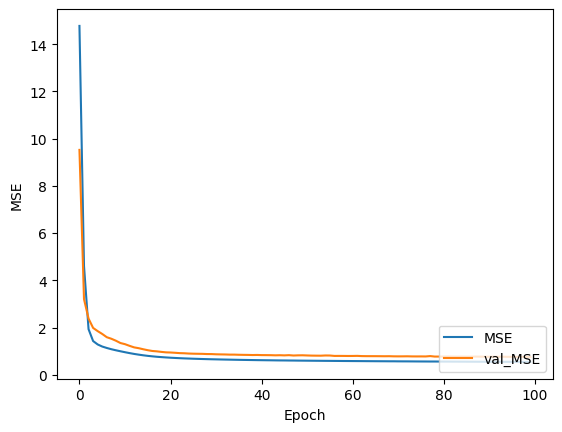

129/129 [==============================] - 0s 2ms/step - loss: 0.5933
The mean squared error on the test data: 0.5933437943458557
129/129 [==============================] - 0s 2ms/step


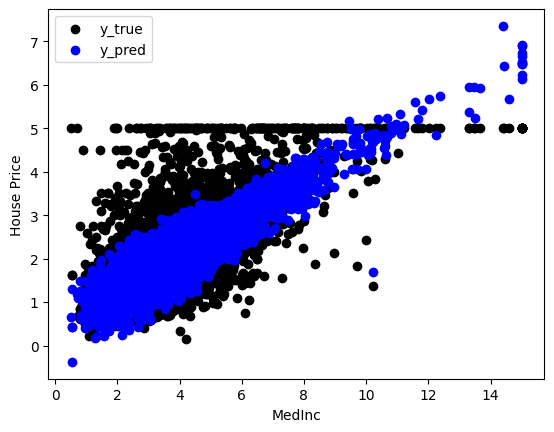

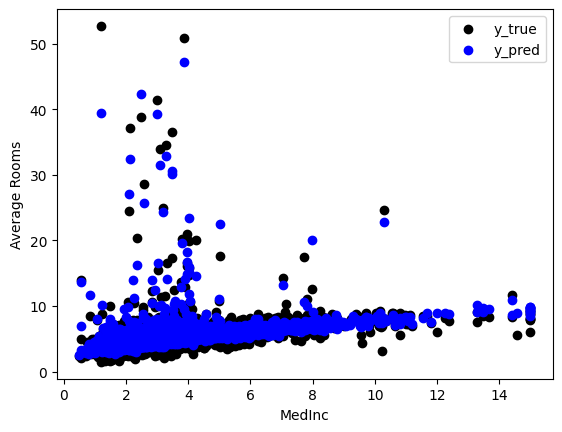

R2 score (House Price): 0.6096
R2 score (Average Rooms): 0.8681


In [ ]:
# Here I am pulling the data into a single frame, then splitting it up into out two column target matrix and our reduced feature matrix (now missing the average rooms)
# There may be a more elegant way to do this process.
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
y_pd = y_pd.to_frame()
Xy_pd = pd.concat([X_pd, y_pd], axis=1)
y_pd=Xy_pd[['MedHouseVal','AveRooms']]
X_pd=Xy_pd
X_pd.drop(columns=['AveRooms','MedHouseVal'], inplace=True)
X_raw = X_pd.to_numpy()
y = y_pd.to_numpy()

X_nontest_raw, X_test_raw, y_nontest, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_nontest_raw, y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

first_layer = Dense(units=10, activation=relu)
second_layer = Dense(units=10, activation=relu)
#############################################
# This is the key step - here we are specifying two output units rather than 1 as we have been doing elsewhere.
out_layer = Dense(units=2, activation=linear)
#############################################

input = Input(shape=X_train.shape[1:])
output = first_layer(input)
output = second_layer(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Appendix_2')
model.summary()

# Compile the model by specifying the optimization algorithm and the loss function.
sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

# Train the model.
history = model.fit(X_train, y_train, batch_size=1000, epochs=100, validation_data=(X_valid, y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

mse_on_test = model.evaluate(X_test, y_test)
print('The mean squared error on the test data:', mse_on_test)

y_test_pred = model.predict(X_test)

# Plot our predictions
# MedInc
plt.scatter(X_test_raw[:,0], y_test[:,0],  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_test_pred[:,0], color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('House Price')
plt.legend()
plt.show()
# AveRooms
plt.scatter(X_test_raw[:,0], y_test[:,1],  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_test_pred[:,1], color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('Average Rooms')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score (House Price): {:.4f}'.format(sklearn.metrics.r2_score(y_test[:,0], y_test_pred[:,0])))
print('R2 score (Average Rooms): {:.4f}'.format(sklearn.metrics.r2_score(y_test[:,1], y_test_pred[:,1])))

#Appendix 3: Image inputs (Bonus Exercise)

Next week we are going to be learning about Convolutional Neural Networks, which are widely used for creating Neural Networks that are good at identifying image features. However, normal Neural Networks are also capable of taking images as an input and classifying them with some accuracy. So, if you want to get a head start on your coursework you might want to have a look at this example of how you can load a dataset I have made of some images and classified them using a standard Neural Network.

First of all, I take the `shapes_dataset,zip` file I provided on moodle and upload it to your colab work space (don't unzip it first!). We can then use this `!unzip` command to extract these files inside colab, where we can start using them.

In [ ]:
!unzip shapes_dataset.zip

unzip:  cannot find or open shapes_dataset.zip, shapes_dataset.zip.zip or shapes_dataset.zip.ZIP.


And we can load the data like so (there are other methods such as using generators that I will touch on next week).

In [ ]:
# We need some extra packages to help us interact with the colab file system and load in the images
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load metadata from the CSV file - this allows us to know what class each picture belongs to.
metadata = pd.read_csv("shapes_dataset/metadata.csv")

# Define the directory where your images are located (in colab in our case)
image_directory = "shapes_dataset"

# Define image size - this means we can rescale all our images to be the same size
image_size = (100, 100)

# Create lists to store image data and labels
images = []
labels = []

# Load and preprocess images
for index, row in metadata.iterrows():
    image_path = os.path.join(image_directory, row['image_name'])
    image = load_img(image_path, target_size=image_size)
    image_array = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
    images.append(image_array)
    labels.append(row['class_label'])

FileNotFoundError: ignored

And now let's visualise the dataset - this is a multi-class classification problem where we have three different shapes to identify!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of rows and columns for image visualization
num_images_to_visualize = 20

num_rows = 4
num_columns = num_images_to_visualize // num_rows

# Get a random subset of images from the validation set
subset_indices = np.random.choice(20, num_images_to_visualize, replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 7))

# Loop through the subset of images
for i, index in enumerate(subset_indices):
    row = i // num_columns
    col = i % num_columns

    imd=(images[index]*255).astype(np.uint8)

    # Plot the image
    axes[row, col].imshow(imd)
    axes[row, col].axis('off')

    # Set the title with both true and predicted labels
    title = f"Label: {labels[index]}\n"
    axes[row, col].set_title(title)

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()


Now let's try solving this with a Neural Network! Pay attention to my comments to understand what is going on.

In [ ]:
from tensorflow.keras.utils import to_categorical # another way to `one hot encode` your target using tensorflow
from tensorflow.keras.layers import Flatten # we need to use the 'flatten' layer to convert our images into a form our 'dense' layers can use.

# Convert class labels to integers
class_mapping = {'square': 0, 'circle': 1, 'triangle': 2}
labels = [class_mapping[label] for label in labels]

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and validation sets
X_non_test, X_test, y_non_test, y_test = train_test_split(images, labels, test_size=1/10, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_non_test, y_non_test, test_size=1/9, random_state=42)

# Convert labels to one-hot encoded format (required for softmax - though we could also use 'sparse' loss/metrics)
y_train_encoded = to_categorical(y_train, num_classes=3)
y_valid_encoded = to_categorical(y_valid, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Define input layer - note this is actually a three channel colour image, we could probably convert to being grayscale for our case, but I will leave it this way for the example.
input_layer = Input(shape=(100, 100, 3))

# Define the model using the functional API
x = Flatten()(input_layer) # we have to flatten our image for the dense layers - makes our data '1D'
x = Dense(1000, activation=relu)(x)
x = Dense(1000, activation=relu)(x)
output_layer = Dense(3, activation=softmax)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using your training data
history = model.fit(X_train, y_train_encoded, epochs=20, validation_data=(X_valid, y_valid_encoded))

# Evaluate the model on the validation and test data
validation_loss, validation_accuracy = model.evaluate(X_valid, y_valid_encoded)
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

print(f"Validation loss: {validation_loss:.4f}")
print(f"Validation accuracy: {validation_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")




Let's evaluate our network now:

In [ ]:
ce_test, acc_test = model.evaluate(X_test, y_test_encoded)
print('The cross entropy loss on the test data:', ce_test)
print('The accuracy on the test data:', acc_test)

y_test_logit = model.predict(X_test)

y_test_pred = np.argmax(y_test_logit, axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_test, dtype=int), y_test_pred))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)

acc_test = accuracy_score(np.array(y_test, dtype=int), y_test_pred)
f1_test = f1_score(np.array(y_test, dtype=int), y_test_pred, pos_label=1, average='macro')
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(np.array(y_test, dtype=int), y_test_pred, pos_label=1, average='macro')
print('Precision on validation data:', pre_test)
reca_test = precision_score(np.array(y_test, dtype=int), y_test_pred, pos_label=1, average='macro')
print('Recall on validation data:', reca_test)

So not too great! Below I'm outputting some examples to see where our model is succeeding and failing.

Bonus exercise: We're likely to reach an accuracy ceiling without going to Convolutional NN's, but you can try adding more nodes, layers and trying the other methods we've covered to see if you can get a better accuracy for this problem!

In [ ]:
# Define the number of rows and columns for image visualization
num_images_to_visualize = 20

num_rows = 4
num_columns = num_images_to_visualize // num_rows

# Get a random subset of images from the validation set
subset_indices = np.random.choice(20, num_images_to_visualize, replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 7))

predicted_prob = model.predict(X_test)
predicted_classes = np.argmax(predicted_prob, axis=1)

predicted_classes_name = predicted_classes

# Loop through the subset of images
for i, index in enumerate(subset_indices):
    row = i // num_columns
    col = i % num_columns

    imd=(X_test[index]*255).astype(np.uint8)

    # Plot the image
    axes[row, col].imshow(imd)
    axes[row, col].axis('off')

    # Set the title with both true and predicted labels
    title = f"True: {y_test[index]}\nPredicted: {predicted_classes[index]}"
    axes[row, col].set_title(title)

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()
